# Import

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_packed_sequence, pad_sequence

import os
import sys
import pickle
import logging
import time
import random

import math
from math import log, ceil

from pathlib import Path
from typing import List, Tuple, Set, Dict

import numpy as np
import pandas as pd
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..')
from src.data import prepare_data, prepare_seq2seq_data, prepare_encdec_data, SOURCE_ASSIST0910_SELF, SOURCE_ASSIST0910_ORIG
from src.utils import sAsMinutes, timeSince

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

# =========================
# PyTorch version & GPU setup
# =========================
print('PyTorch:', torch.__version__)
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dev = torch.device('cpu')
print('Using Device:', dev)

PyTorch: 1.0.1.post2
Using Device: cuda


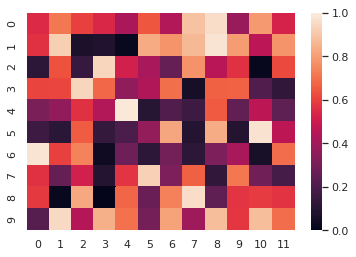

In [11]:
_d = np.random.rand(10,12)
ax = sns.heatmap(_d, vmin=0, vmax=1)

In [12]:
# =========================
# Seed
# =========================
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# =========================
# Parameters
# =========================
# model_name = 'RNN'
sequence_size = 20
epoch_size = 100
lr = 0.1
batch_size, n_hidden, n_skills, n_layers = 100, 200, 124, 1
n_output = n_skills
PRESERVED_TOKENS = 2  # PAD, SOS
onehot_size = n_skills * 2 + PRESERVED_TOKENS
n_input = ceil(log(2 * n_skills))
# n_input = onehot_size  #

NUM_EMBEDDIGNS, ENC_EMB_DIM, ENC_DROPOUT = onehot_size, n_input, 0.6
OUTPUT_DIM, DEC_EMB_DIM, DEC_DROPOUT = onehot_size, n_input, 0.6
# OUTPUT_DIM = n_output = 124  # TODO: ほんとはこれやりたい
HID_DIM, N_LAYERS = n_hidden, n_layers

# =========================
# Data
# =========================
train_dl, eval_dl = prepare_encdec_data(
    SOURCE_ASSIST0910_ORIG, n_skills, PRESERVED_TOKENS, min_n=3, max_n=sequence_size, batch_size=batch_size, device=dev, sliding_window=1)

# 違いを調整する <- ???
#OUTPUT_DIM = eval_dl.dataset.tensors[1].shape

Level 25:dkt log:EVAL  Epoch: 0 Loss: 0.6528912385304769
Level 25:dkt log:EVAL  Epoch: 0 AUC: 0.7113665389527459


The model has 386,050 trainable parameters
starting


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

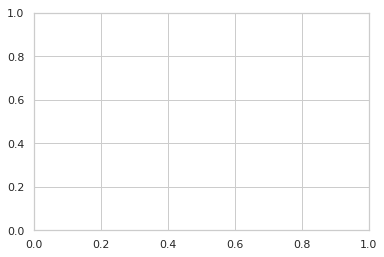

In [15]:
# =========================
# Model
# =========================
class Encoder(nn.Module):
    def __init__(self, num_embeddings, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        # Layers
        self.embedding = nn.Embedding(num_embeddings, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell
    
    
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        # Layers
        self.embedding = nn.Embedding(output_dim, emb_dim)  # 250->6
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)  # 6, 100, 1
        
        self.out = nn.Linear(hid_dim, output_dim)  # 100, 250
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))
        return prediction, hidden, cell

    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, dev):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = dev
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
    
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        max_len = trg.shape[0]  # should be 1
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        hidden, cell = self.encoder(src)
        
        input_trg = trg[0,:]  # should be 1, 100, ?
         
        output, hidden, cell = self.decoder(input_trg, hidden, cell)
        outputs = output.unsqueeze(0)
        o_wro = torch.sigmoid(output[:, 2:2+124])
        o_cor = torch.sigmoid(output[:, 2+124:])
        outputs_prob = (o_cor / (o_cor + o_wro)).unsqueeze(0)
        
        return outputs, outputs_prob
    
    

# =========================
# Prepare and Train
# =========================
enc = Encoder(NUM_EMBEDDIGNS, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, dev).to(dev)

    
load_model = '/home/qqhann/qqhann-paper/ECML2019/dkt_neo/models/encdec_2019_0405_0429.800'
if load_model:
    epoch_start = int(load_model.split('.')[-1]) + 1
    model.load_state_dict(torch.load(load_model))
    model = model.to(dev)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


loss_func = nn.BCELoss()
opt = optim.SGD(model.parameters(), lr=lr)


def loss_batch(model, loss_func, *args, opt=None):
    # Unpack data from DataLoader
    xs_src, xs_trg, ys, yq, ya, yp = args
    input_src = xs_src
    input_trg = xs_trg
    target = ys
    input_src = input_src.permute(1, 0)
    input_trg = input_trg.permute(1, 0)
    target = target.permute(1, 0)

    out, out_prob = model(input_src, input_trg)
    out = out.permute(1, 0, 2)
    out_prob = out_prob.permute(1, 0, 2)

    pred = torch.sigmoid(out)  # [0, 1]区間にする

    # --- 指標評価用データ
    prob = torch.max(out_prob * yq[:,-1,:].unsqueeze(1), 2)[0]
    predicted = prob
    actual = ya[:,-1]
    # ---

    loss = loss_func(prob[:,-1], ya[:,-1]) 

    if opt:
        # バックプロバゲーション
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    # Returns loss number, batch size
    return loss.item(), len(ys), predicted, actual
    


def main():
    debug = False 
    logging.basicConfig()
    logger = logging.getLogger('dkt log')
    logger.setLevel(logging.INFO)
    train_loss_list = []
    train_auc_list = []
    eval_loss_list = []
    eval_auc_list = []
    eval_recall_list = []
    eval_f1_list = []
    x = []
    start_time = time.time()
    epoch = 0
    print_train = epoch % 10 == 0
    print_eval = epoch % 10 == 0
    print_auc = epoch % 10 == 0
    
    # =====
    # EVAL
    # =====
    with torch.no_grad():
        model.eval()

        val_pred = []
        val_actual = []
        current_eval_loss = []
        for args in eval_dl:
            loss_item, batch_n, pred, actu = loss_batch(model, loss_func, *args, opt=None)
            current_eval_loss.append(loss_item)
            val_pred.append(pred)
            val_actual.append(actu)

            # stop at first batch if debug
            if debug:
                break

        loss = np.array(current_eval_loss)
        logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0), 
                   'EVAL  Epoch: {} Loss: {}'.format(epoch,  loss.mean()))
        eval_loss_list.append(loss.mean())

        # AUC, Recall, F1
        if print_auc:
            y = torch.cat(val_actual).view(-1).cpu()  # TODO: viewしない？　最後の1個で？
            pred = torch.cat(val_pred).view(-1).cpu()
            # AUC
            fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
            logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0), 
                       'EVAL  Epoch: {} AUC: {}'.format(epoch, metrics.auc(fpr, tpr)))
            eval_auc_list.append(metrics.auc(fpr, tpr))
        #     # Recall
        #     logger.debug('EVAL  Epoch: {} Recall: {}'.format(epoch, metrics.recall_score(y, pred.round())))
        #     # F1 score
        #     logger.debug('EVAL  Epoch: {} F1 score: {}'.format(epoch, metrics.f1_score(y, pred.round())))
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, eval_auc_list, label='eval auc')
    ax.legend()
    print(len(train_loss_list), len(eval_loss_list), len(eval_auc_list))
    plt.show()

if __name__ == '__main__':
    print('starting')
    main()

In [16]:
all_out_prob[0].shape

torch.Size([100, 124])

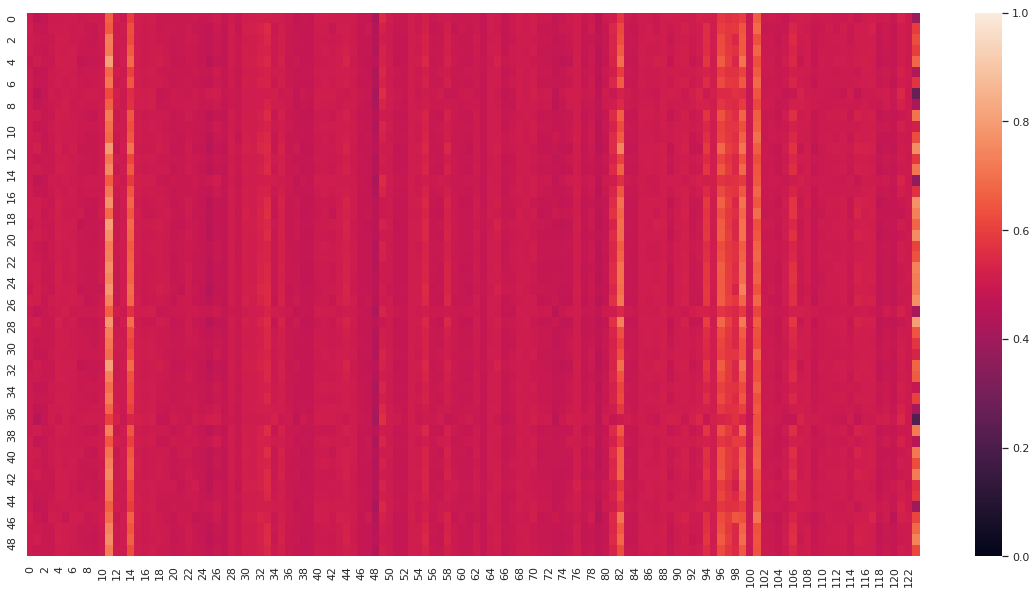

In [24]:
_d = all_out_prob[0].cpu()[:50]
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(_d, vmin=0, vmax=1, ax=ax)

In [30]:
loss = nn.BCELoss()
loss(torch.sigmoid(torch.randn(1, 5)), torch.sigmoid(torch.randn(1, 5)))

tensor(0.8441)